📘 Machine Learning-Based Pairs Trading Strategy
---------------------------------------------------------------

### 📝 Introduction

Pairs trading is a market-neutral trading strategy that identifies two historically correlated securities. When their price relationship diverges temporarily, it offers a trading opportunity — short the outperforming one and long the underperforming one, expecting convergence.

In this project:

*   We cluster stocks based on return characteristics.
    
*   Select cointegrated pairs.
    
*   Use Z-score for trading signals.
    
*   Apply a simple backtesting framework.
    

### 📦 Step 1: Import Required Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint

### 📊 Step 2: Download Historical Price Data

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'IBM', 'INTC', 'ORCL']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Close']

[*********************100%***********************]  10 of 10 completed


### 📈 Step 3: Calculate Log Returns

In [ ]:
returns = np.log(data / data.shift(1)).dropna()

### 🧮 Step 4: Feature Engineering for Clustering

We use:

*   **Mean Return**: Average daily log return
    
*   **Volatility**: Standard deviation of log returns

In [ ]:
features = pd.DataFrame()
features['mean_return'] = returns.mean()
features['volatility'] = returns.std()


### 🧪 Step 5: Normalize Features and Apply KMeans Clustering

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

### 📍 Step 6: Visualize Clusters

<ipython-input-16-06245048cb43>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (features['mean_return'][i], features['volatility'][i]))


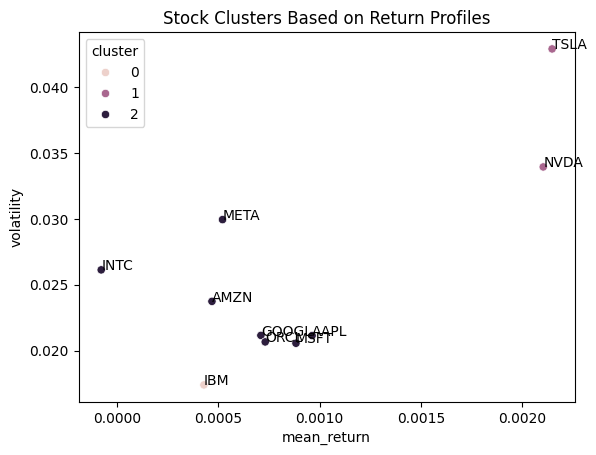

In [ ]:
sns.scatterplot(x=features['mean_return'], y=features['volatility'], hue=features['cluster'])
for i, txt in enumerate(features.index):
    plt.annotate(txt, (features['mean_return'][i], features['volatility'][i]))
plt.title("Stock Clusters Based on Return Profiles")
plt.xlabel("mean_return")
plt.ylabel("volatility")
plt.show()

### 🔍 Step 7: Identify Cointegrated Pairs within Each Cluster

In [ ]:
selected_pairs = []
for cluster in features['cluster'].unique():
    members = features[features['cluster'] == cluster].index.tolist()
    for i in range(len(members)):
        for j in range(i+1, len(members)):
            s1, s2 = members[i], members[j]
            score, pvalue, _ = coint(data[s1], data[s2])
            if pvalue < 0.05:
                selected_pairs.append((s1, s2, round(pvalue, 4)))

print("Cointegrated Pairs:")
for pair in selected_pairs:
    print(f"{pair[0]} - {pair[1]} (p-value={pair[2]})")

Cointegrated Pairs:


### 📐 Step 8: Z-Score Based Strategy for GOOGL-MSFT

We use the spread between the two stocks and calculate the Z-score for generating signals.

In [ ]:
def compute_zscore(spread):
    return (spread - spread.mean()) / spread.std()

spread = data['GOOGL'] - data['MSFT']
zscore = compute_zscore(spread)

### 📊 Step 9: Plot Z-score to Visualize Signal Levels

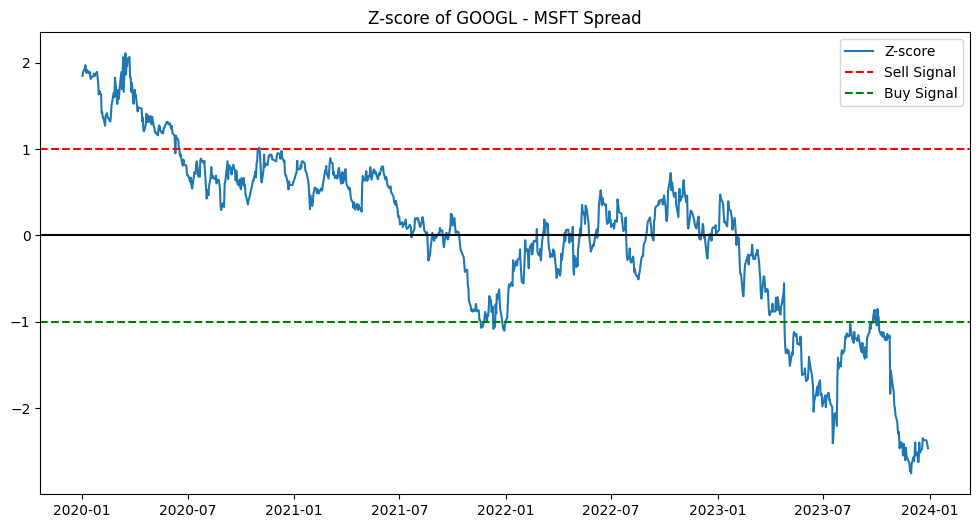

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(zscore, label='Z-score')
plt.axhline(1.0, color='red', linestyle='--', label='Sell Signal')
plt.axhline(-1.0, color='green', linestyle='--', label='Buy Signal')
plt.axhline(0.0, color='black', linestyle='-')
plt.legend()
plt.title("Z-score of GOOGL - MSFT Spread")
plt.show()

### 🔁 Step 10: Backtest Strategy

Basic logic:

*   **Buy GOOGL, Sell MSFT** when Z < -1
    
*   **Sell GOOGL, Buy MSFT** when Z > 1
    
*   **Exit** positions when Z ~ 0

In [ ]:
positions = pd.DataFrame(index=data.index)
positions['GOOGL'] = 0
positions['MSFT'] = 0

# Long GOOGL, Short MSFT
positions['GOOGL'][zscore < -1] = 1
positions['MSFT'][zscore < -1] = -1

# Short GOOGL, Long MSFT
positions['GOOGL'][zscore > 1] = -1
positions['MSFT'][zscore > 1] = 1

# Exit
positions['GOOGL'][abs(zscore) < 0.2] = 0
positions['MSFT'][abs(zscore) < 0.2] = 0

positions = positions.fillna(method='ffill')

<ipython-input-20-242d443bee70>:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  positions['GOOGL'][zscore < -1] = 1
<ipython-input-20-242d443bee70>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setti

### 📈 Step 11: Calculate Strategy Returns

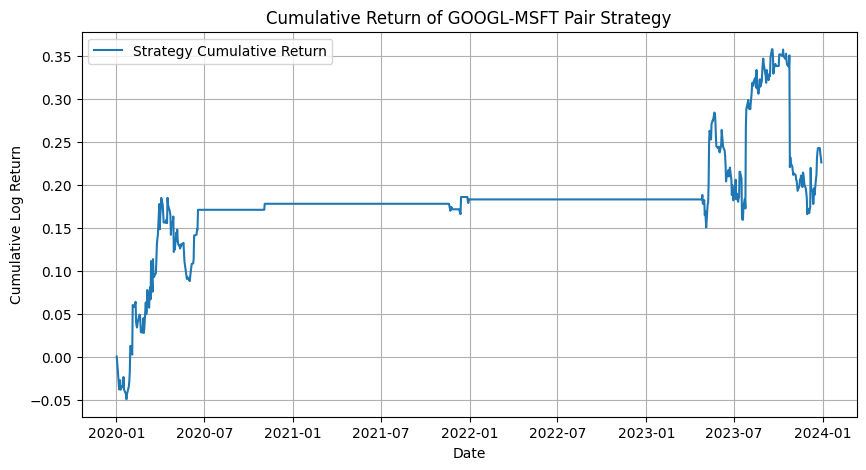

In [ ]:
strategy_returns = (positions.shift(1) * returns[['GOOGL', 'MSFT']]).sum(axis=1)
cumulative_returns = strategy_returns.cumsum()

plt.figure(figsize=(10,5))
plt.plot(cumulative_returns, label='Strategy Cumulative Return')
plt.title("Cumulative Return of GOOGL-MSFT Pair Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid()
plt.show()

### ✅ Conclusion

*   **ML-based clustering** helps shortlist similar stocks.
    
*   **Cointegration** ensures pairs are statistically linked.
    
*   **Z-score** trading strategy offers a mean-reversion edge.
    
*   Simple **backtest** shows profitability from exploiting deviations.